In [85]:
import gymnasium as gym
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [86]:
env = gym.make('CartPole-v1')

In [87]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = nn.Sequential(
                nn.Linear(n_state, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_action),
                nn.Softmax(),
            )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def predict(self, s):
        """
        Вычисляет вероятности действий в состоянии s,
        применяя обученную модель
        @param s: входное состояние
        @return: предсказанная стратегия
        """
        return self.model(torch.Tensor(s))
    
    def update(self, returns, log_probs):
        """
        Обновляет веса сети стратегии на основе обучающих примеров
        @param returns: доход (накопительное вознаграждение) на каждом
        шаге эпизода
        @param log_probs: логарифмы вероятностей на каждом шаге
        """
        policy_gradient = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_gradient.append(-log_prob * Gt)

        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        """
        Предсказывает стратегию, выбирает действие и вычисляет логарифм
        его вероятности
        @param s: входное состояние
        @return: выбранное действие и логарифм его вероятности
        """
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob
    
    

In [88]:
def reinforce(env, estimator, n_episode, total_reward_episode, gamma=1.0):
    """
    Алгоритм REINFORCE
    @param env: имя окружающей среды Gym
    @param estimator: сеть, аппроксимирующая стратегию

    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    """
    for episode in tqdm(range(n_episode)):
        log_probs = []
        rewards = []
        state, _ = env.reset()
        while True:
            action, log_prob = estimator.get_action(state)
            next_state, reward, is_done, is_break, _ = env.step(action)
            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            rewards.append(reward)

            if is_done or is_break:
                returns = []
                Gt = 0
                pw = 0
                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)
                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean()) / ( returns.std() + 1e-9)
                estimator.update(returns, log_probs)
                #print('Эпизод: {}, полное вознаграждение: {} {} {}'.format(episode, total_reward_episode[episode], is_done , is_break))
                break
            state = next_state

In [89]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.003
gamma = 0.9
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)
n_episode = 500
total_reward_episode = [0] * n_episode
reinforce(env, policy_net, n_episode, total_reward_episode, gamma)

100%|██████████| 500/500 [00:36<00:00, 13.70it/s]


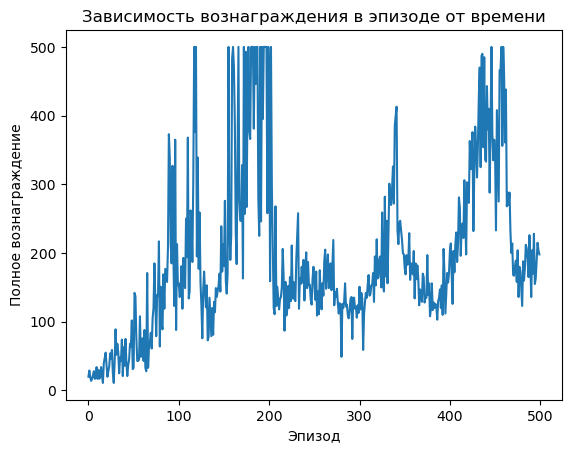

In [90]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()